# Color Palette Identification using KNN and Gradio


In [ ]:
!pip install -q gradio pandas scikit-learn pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 137.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import gradio as gr
import seaborn as sns

Hex→RGB mismatches: 18

Loaded 1157 unique named colors


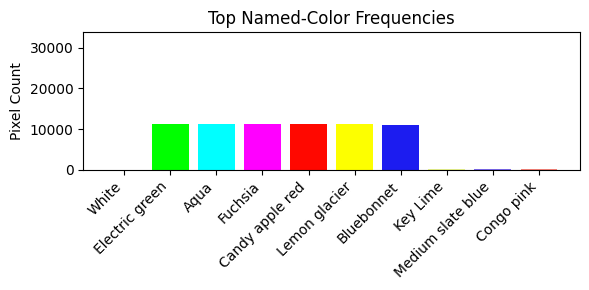

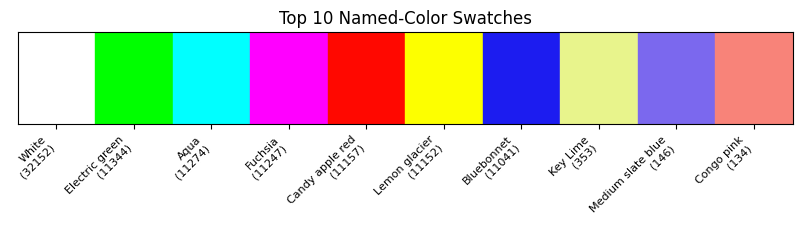

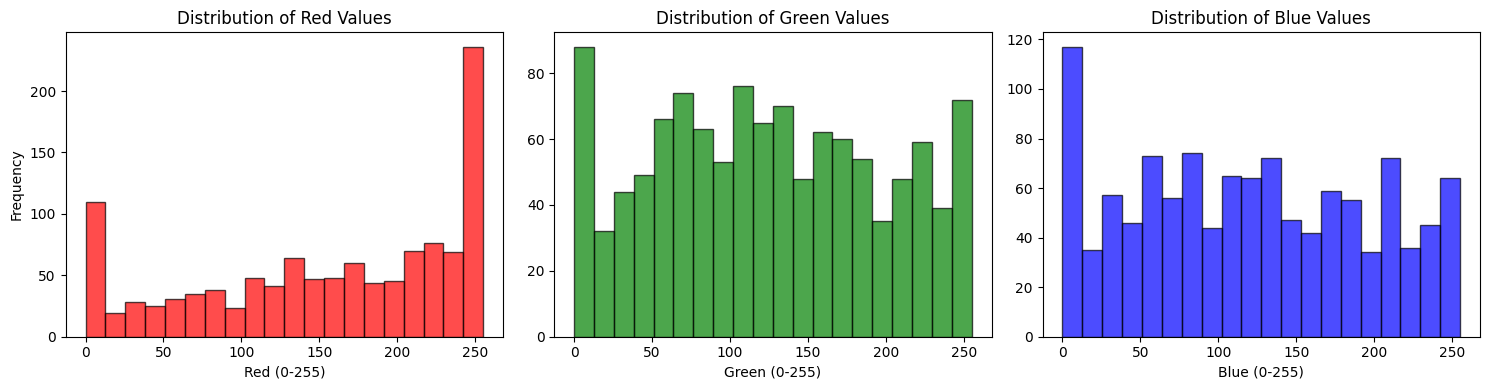

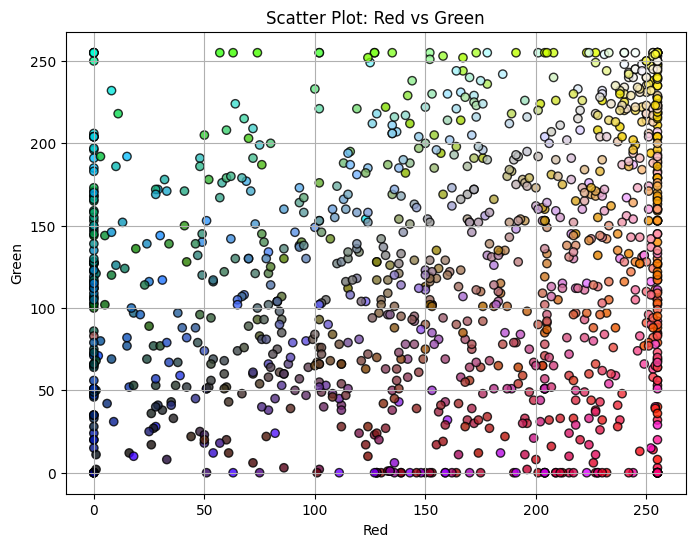

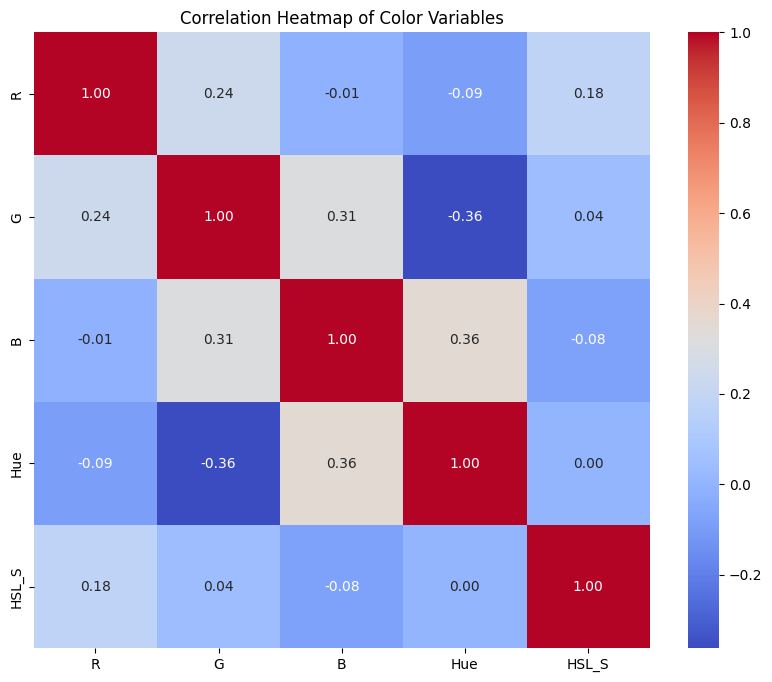

In [ ]:
# --------------------------
# Load and Clean the Color Data
# --------------------------
df = pd.read_csv('./color_names.csv')

# Rename columns to simpler names.
# Adjust the renaming dictionary based on the actual column names in your file.
rename_dict = {
    'Name': 'Name',
    'Hex (24 bit)': 'Hex',
    'Red (8 bit)': 'R',
    'Green (8 bit)': 'G',
    'Blue (8 bit)': 'B',
    'Hue (degrees)': 'Hue',
    'HSL.S (%)': 'HSL_S',
    'HSL.L (%)': 'HSL_L',  # If this column does not exist, this key may be removed.
    'HSV.S (%)': 'HSV_S',
    'HSV.V (%)': 'HSV_V'
}
df = df.rename(columns=rename_dict)

# Remove rows where any essential RGB column is NaN
df = df.dropna(subset=['R', 'G', 'B'])

# Convert RGB columns to integers
df[['R', 'G', 'B']] = df[['R', 'G', 'B']].astype(int)

# ----------------------------------
# Additional Preprocessing Steps
# ----------------------------------

# 1. Ensure other color-related columns are numeric.
# Define all possible numeric columns.
possible_numeric_cols = ['Hue', 'HSL_S', 'HSL_L', 'HSV_S', 'HSV_V']
# Only process columns that exist in the DataFrame.
numeric_cols = [col for col in possible_numeric_cols if col in df.columns]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Remove rows with out-of-range RGB values (valid range is 0-255)
df = df[(df['R'] >= 0) & (df['R'] <= 255)]
df = df[(df['G'] >= 0) & (df['G'] <= 255)]
df = df[(df['B'] >= 0) & (df['B'] <= 255)]

# 3. Clean and normalize the Name column (strip whitespace)
df['Name'] = df['Name'].astype(str).str.strip()
# Optionally, uncomment one of the next two lines for uniform casing:
# df['Name'] = df['Name'].str.lower()
# df['Name'] = df['Name'].str.upper()

# 4. Normalize the Hex column: remove extra spaces, convert to uppercase.
df['Hex'] = df['Hex'].astype(str).str.strip().str.upper()

# 5. Remove duplicate rows based on the RGB values.
df = df.drop_duplicates(subset=['R', 'G', 'B']).reset_index(drop=True)

# ----------------------------------
# Optional: Verify Hex vs. RGB values
# ----------------------------------
# Extract RGB values from the Hex column safely.
def safe_hex_to_int(s, start, end):
    try:
        hex_part = s.lstrip('#')[start:end]
        return int(hex_part, 16) if len(hex_part) == 2 else np.nan
    except Exception:
        return np.nan

df['hR'] = df['Hex'].apply(lambda x: safe_hex_to_int(x, 0, 2))
df['hG'] = df['Hex'].apply(lambda x: safe_hex_to_int(x, 2, 4))
df['hB'] = df['Hex'].apply(lambda x: safe_hex_to_int(x, 4, 6))

# Count mismatches between the computed hex RGB values and the provided RGB values.
mismatches = ((df['hR'] != df['R']) | (df['hG'] != df['G']) | (df['hB'] != df['B'])).sum()
print(f"Hex→RGB mismatches: {mismatches}")

print(f"\nLoaded {len(df)} unique named colors")

# --------------------------
# Plotting Section
# --------------------------

# 1. Plot Histograms for RGB channels
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(df['R'], bins=20, color='red', edgecolor='black', alpha=0.7)
plt.title('Distribution of Red Values')
plt.xlabel('Red (0-255)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['G'], bins=20, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Green Values')
plt.xlabel('Green (0-255)')

plt.subplot(1, 3, 3)
plt.hist(df['B'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Blue Values')
plt.xlabel('Blue (0-255)')

plt.tight_layout()
plt.show()

# 2. Scatter Plot: Red vs Green, with each point colored by its Hex value.
plt.figure(figsize=(8, 6))

# Function to ensure valid hex values for plotting.
def valid_hex_code(h):
    h = h.strip()
    if not h.startswith('#'):
        h = '#' + h
    return h if len(h) == 7 else f"#{h.lstrip('#'):0>6}"

colors_for_plot = df['Hex'].apply(valid_hex_code).tolist()

plt.scatter(df['R'], df['G'], c=colors_for_plot, edgecolor='k', alpha=0.8)
plt.title('Scatter Plot: Red vs Green')
plt.xlabel('Red')
plt.ylabel('Green')
plt.grid(True)
plt.show()

# 3. Correlation Heatmap for Numeric Columns
# Prepare a list of numeric columns including RGB and any additional numeric columns.
cols_for_corr = ['R', 'G', 'B'] + numeric_cols
corr = df[cols_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Color Variables')
plt.show()


In [ ]:
# Fit KNN model
knn_model = NearestNeighbors(n_neighbors=1).fit(df[['R','G','B']].values)

def identify_palette(img, topN=5):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img.astype('uint8'))
    elif not isinstance(img, Image.Image):
        raise ValueError(f"Unsupported image type: {type(img)}")

    pix = np.array(img.convert('RGB')).reshape(-1,3)
    if pix.shape[0] > 100_000:
        idx = np.random.choice(pix.shape[0], 100_000, replace=False)
        pix = pix[idx]

    kmeans = KMeans(n_clusters=topN, random_state=42)
    kmeans.fit(pix)
    centers = kmeans.cluster_centers_.astype(int)
    _, inds = knn_model.kneighbors(centers)
    counts = np.bincount(kmeans.labels_)

    res = pd.DataFrame({
        'Name': df.loc[inds[:,0], 'Name'].values,
        'R'   : df.loc[inds[:,0], 'R'].values,
        'G'   : df.loc[inds[:,0], 'G'].values,
        'B'   : df.loc[inds[:,0], 'B'].values,
        'Count': [counts[i] for i in range(topN)]
    }).sort_values('Count', ascending=False).reset_index(drop=True)

    fig1, ax1 = plt.subplots(figsize=(6,3))
    top = res.head(topN)
    ax1.bar(
        top['Name'], top['Count'],
        color=[(r/255, g/255, b/255) for r,g,b in zip(top['R'],top['G'],top['B'])]
    )
    ax1.set_xticklabels(top['Name'], rotation=45, ha='right')
    ax1.set_ylabel("Pixel Count")
    ax1.set_title("Top Named-Color Frequencies")
    plt.tight_layout()

    fig2, ax2 = plt.subplots(figsize=(topN,1.2))
    for i, row in top.iterrows():
        ax2.add_patch(Rectangle((i,0),1,1,
                                color=(row['R']/255, row['G']/255, row['B']/255)))
    ax2.set_xlim(0, topN); ax2.set_ylim(0,1)
    ax2.set_xticks(np.arange(topN)+0.5)
    ax2.set_xticklabels(
        [f"{n}\n({c})" for n,c in zip(top['Name'],top['Count'])],
        rotation=45, ha='right', fontsize=8
    )
    ax2.set_yticks([])
    ax2.set_title(f"Top {topN} Named-Color Swatches")
    plt.tight_layout()

    return fig1, fig2

In [ ]:
# Gradio demo
demo = gr.Interface(
    fn=identify_palette,
    inputs=[
        gr.Image(type='numpy', label='Upload Image'),
        gr.Slider(1, len(df), value=5, step=1, label='Top N Colors')
    ],
    outputs=[
        gr.Plot(label='Color Frequencies'),
        gr.Plot(label='Color Swatches')
    ],
    title="🎨 Full Named-Color Palette Identifier",
    description=(
        "Upload an image and match each pixel to its nearest named color "
        "from your dataset (Name, Hex, RGB, HSL, HSV)."
    ),
    allow_flagging='never'
)

# Launch app
demo.launch(share=True)

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d0397c9a826fecf09c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
